In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
import brian2 as b2
from brian2 import ms
import brian2hears as b2h
import matplotlib.pyplot as plt
import numpy as np

from analyze import sound_analysis as SA
from cochleas.GammatoneCochlea import run_hrtf
from utils.custom_sounds import Tone, WhiteNoise
from utils.log import logger
import nest

2025-01-10 15:23:27,573 [INFO ]  

>>>>> start execution

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:33:06

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



# ILD only

approssimazione: puntiamo all'effetto di una HRTF, solo in termini di ILD. Questo significa:
- passare il suono in input in una HRTF esistente -> `GammatoneCochlea.run_hrtf`
- analizzare i due lati per identificare qual è l'ITD -> `analyze.sound_analysis.itd`
- anticipare il lato che sente il suono in ritardo per allinearlo all'altro -> basarsi su `HeadlessDatabase`

Il risultato di questa operazione sarà, però, che il momento in cui "i due suoni arrivano alle ANF" (o più propriamente: il momento in cui il segnale mostra l'effetto dei suoni) cambierà tra una posizione e l'altra. Se questo non ci piace, si può risolvere, per ora puntiamo a ottenere l'effetto sperato.


WARNING    /home/paolo/Documents/school/master/polimi/thesis/polithesis/src/analyze/sound_analysis.py:57: UserWarning:FigureCanvasAgg is non-interactive, and thus cannot be shown
 [py.warnings]


WHEN USING SYNTHETIC
22.67573696 us
-158.73015873 us
-45.35147392 us
-158.73015873 us
68.02721088 us
45.35147392 us
204.08163265 us


WARNING    /home/paolo/Documents/school/master/polimi/thesis/polithesis/src/analyze/sound_analysis.py:36: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
 [py.warnings]


-22.67573696 us
-68.02721088 us
-181.40589569 us
-136.05442177 us
90.70294785 us
113.37868481 us


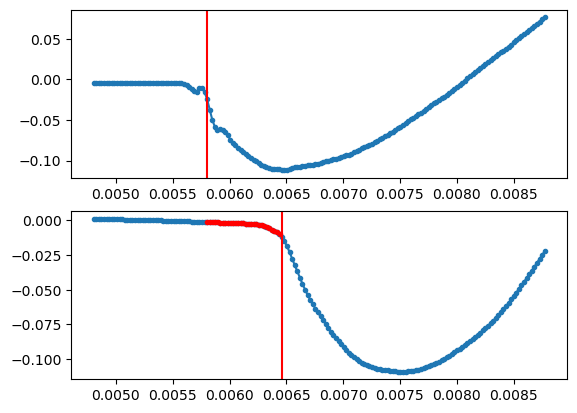

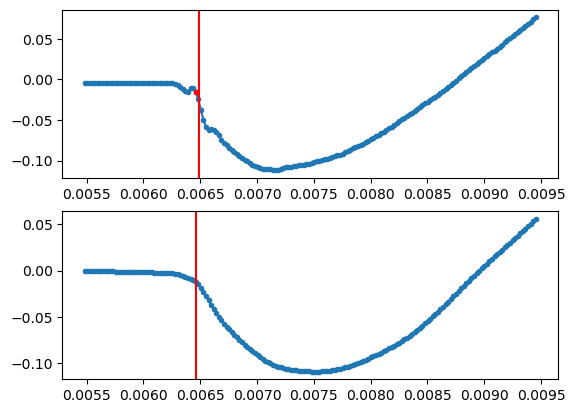

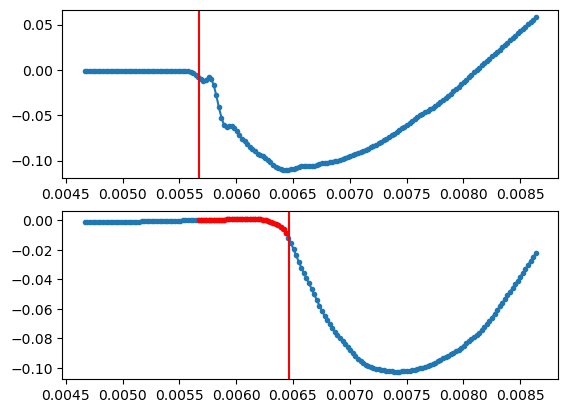

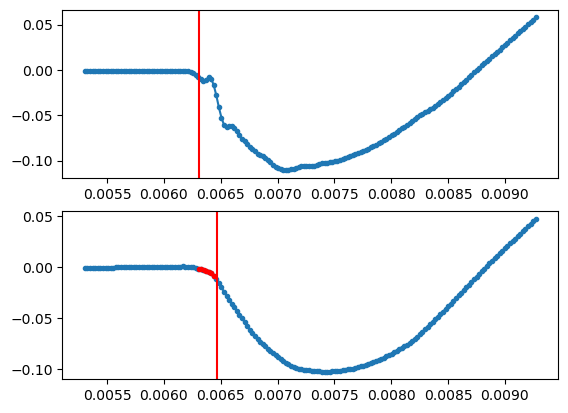

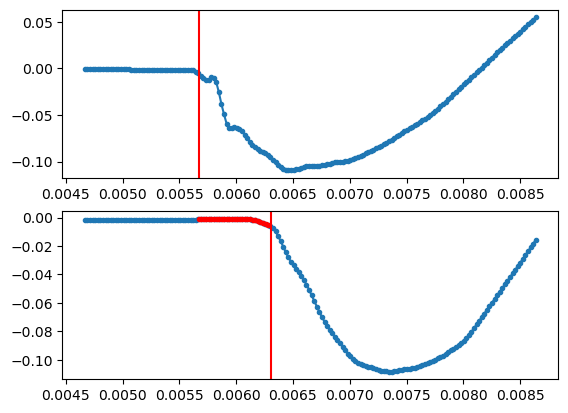

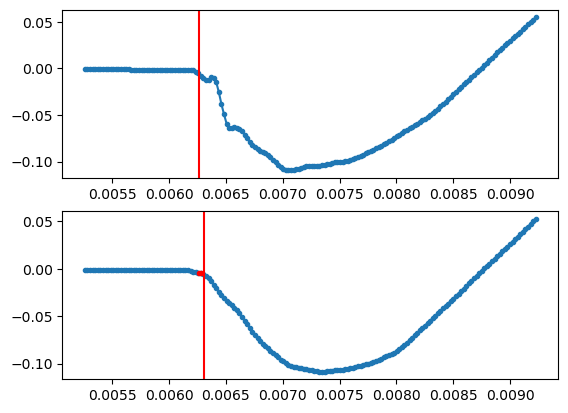

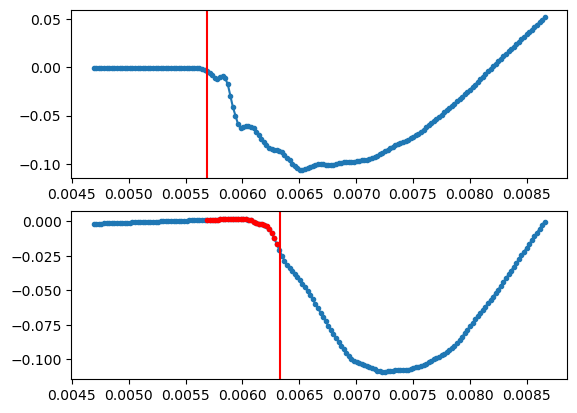

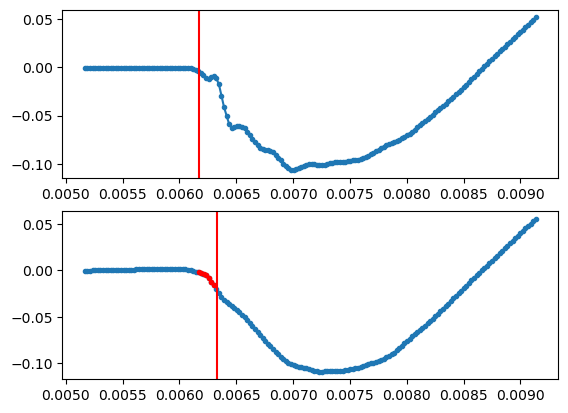

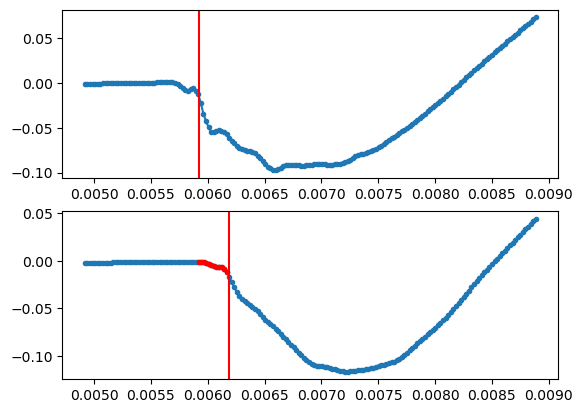

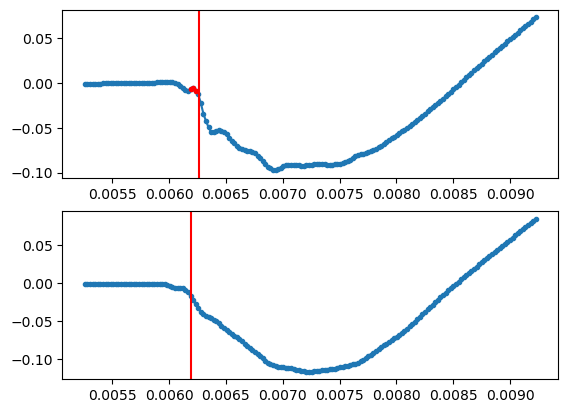

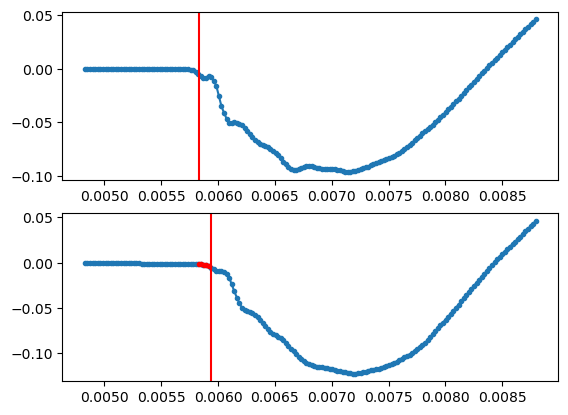

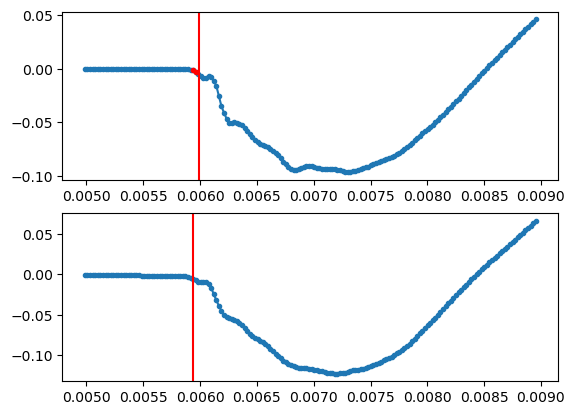

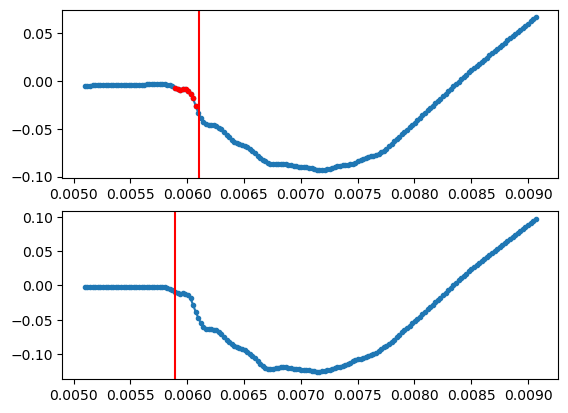

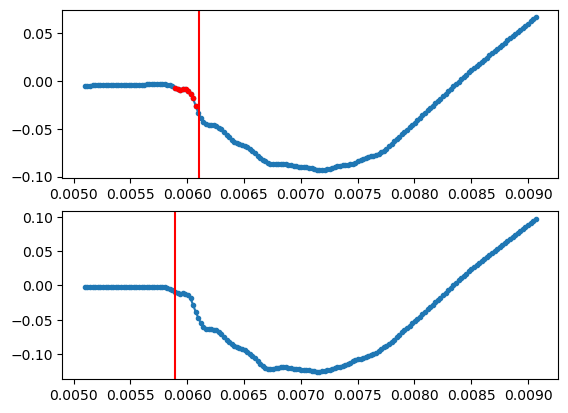

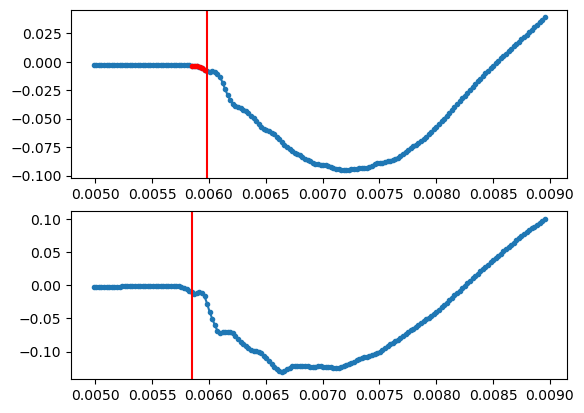

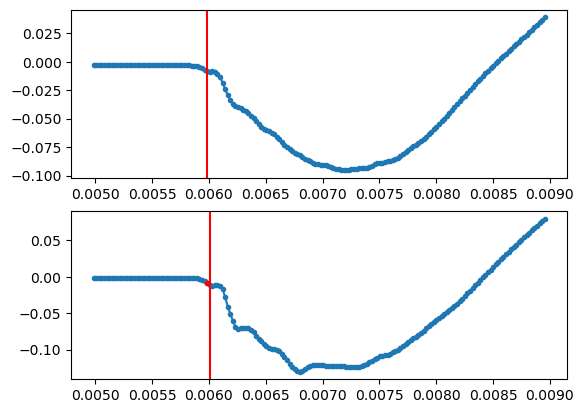

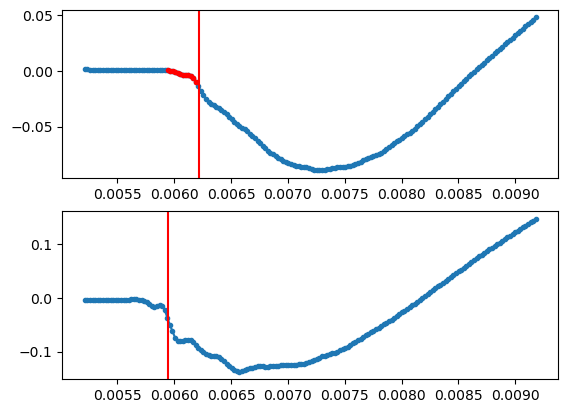

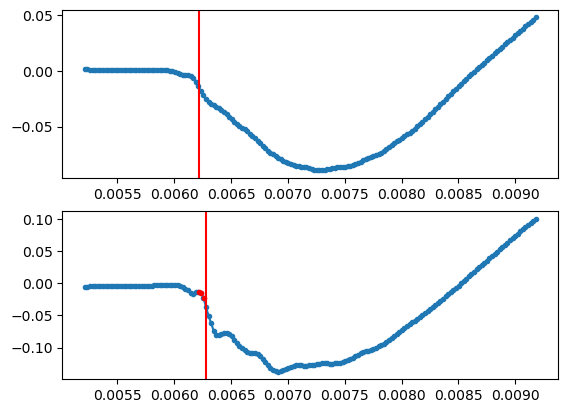

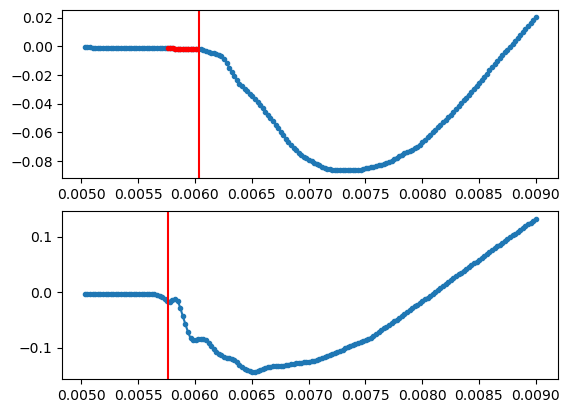

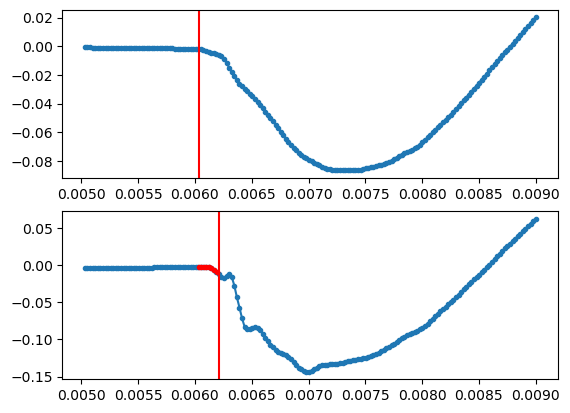

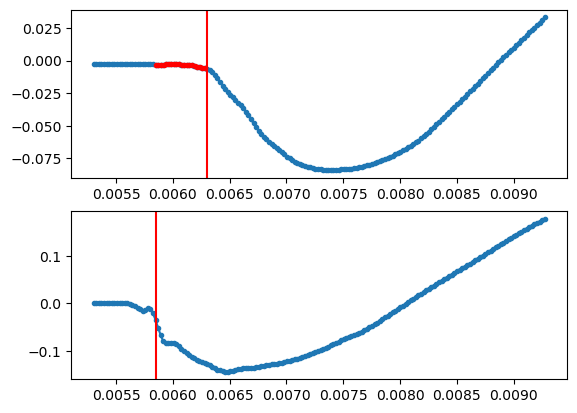

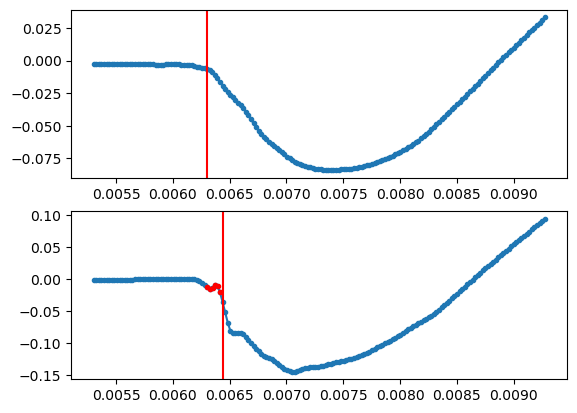

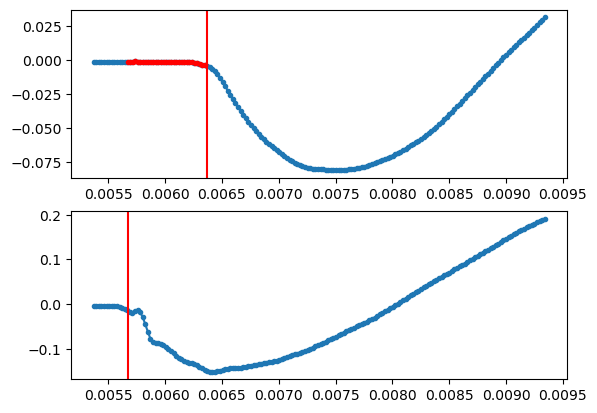

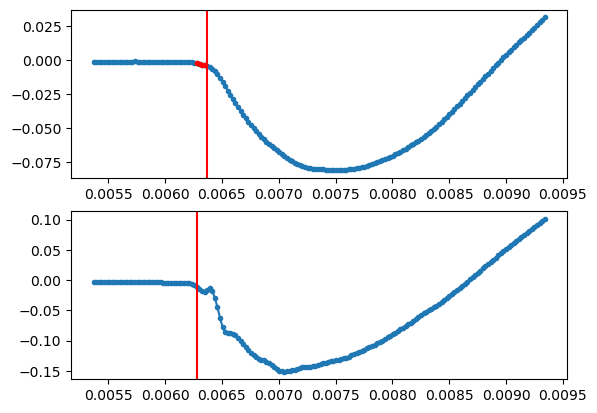

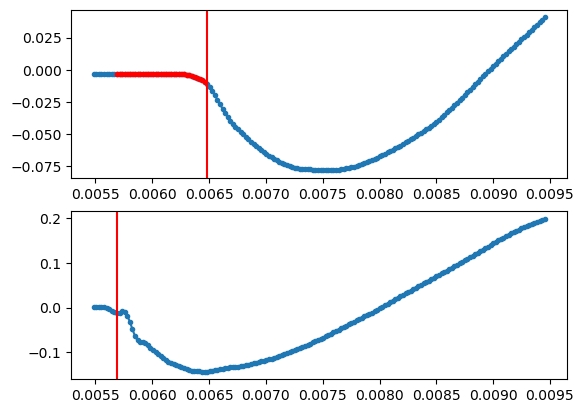

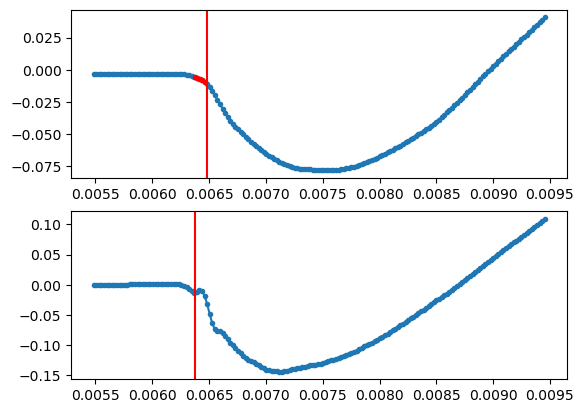

In [68]:
from brian2hears import Sound
from enum import Enum
import logging

ITD_STRATEGY = Enum("ITD_STRATEGY", "ESTIMATE_FROM_HRTF SYNTHETIC")



def sel_range(s, start=0 * ms, end=10 * ms):
    return s[start:end]


def angle_to_itd(angle, w_head: int = 22, v_sound: int = 33000):
    delta_x = w_head * np.sin(np.deg2rad(angle))
    return round(1000 * delta_x / v_sound, 2) * b2.ms


def apply_ILD_only_HRTF(sound, angle, subj_number=4, STRAT=ITD_STRATEGY.SYNTHETIC):
    binaural_sound = run_hrtf(sound, ANGLE, subj=subj_number)
    left = Sound(binaural_sound.left)
    right = Sound(binaural_sound.right)

    s_itd = SA.itd(left, right, display=True)
    logger.debug(f"current ITD is {s_itd}")
    logger.debug(f"synthetic ITD for current angle {angle} is {angle_to_itd(ANGLE)}")

    if STRAT == ITD_STRATEGY.ESTIMATE_FROM_HRTF:
        pass
    elif STRAT == ITD_STRATEGY.SYNTHETIC:
        s_itd = angle_to_itd(ANGLE)

    if s_itd < 0:
        # sound comes from left, include delay
        left = left.shifted(abs(s_itd))
    elif s_itd > 0:
        # sound comes from right, include delay
        right = right.shifted(abs(s_itd))

    corrected_itd = SA.itd(left, right, display=True)
    logger.debug(f"after correction, ITD is {corrected_itd} (should be close to zero)")
    return corrected_itd

plt.close()
nest.set_verbosity("M_ERROR")

sound = Tone(100 * b2.Hz, 50 * b2.ms)
ANGLE = -30
print("WHEN USING SYNTHETIC")
for ANGLE in range(-90,91,15):
    logger.setLevel(logging.WARNING)
    itd = apply_ILD_only_HRTF(sound,ANGLE,STRAT=ITD_STRATEGY.SYNTHETIC)
    print(itd)



WARNING    /home/paolo/Documents/school/master/polimi/thesis/polithesis/src/analyze/sound_analysis.py:57: UserWarning:FigureCanvasAgg is non-interactive, and thus cannot be shown
 [py.warnings]


WHEN USING HRTF ESTIMATE
0. s
0. s
0. s
0. s
0. s
0. s
0. s


WARNING    /home/paolo/Documents/school/master/polimi/thesis/polithesis/src/analyze/sound_analysis.py:36: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
 [py.warnings]


0. s
0. s
22.67573696 us
0. s
22.67573696 us
0. s


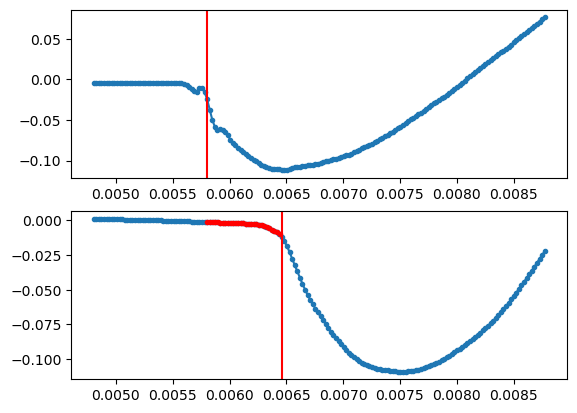

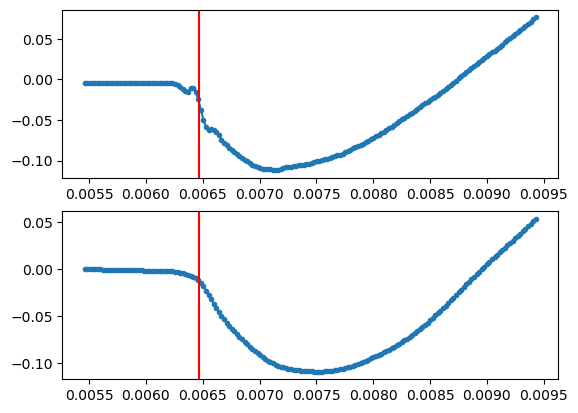

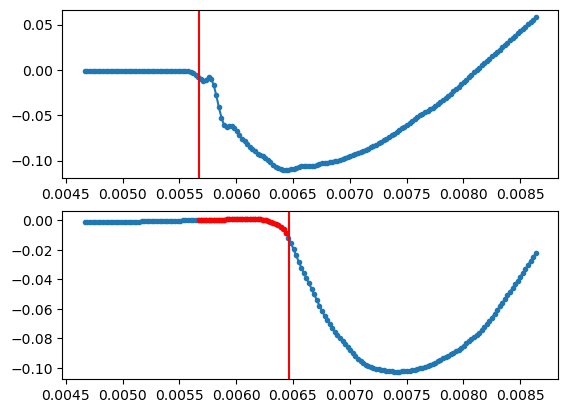

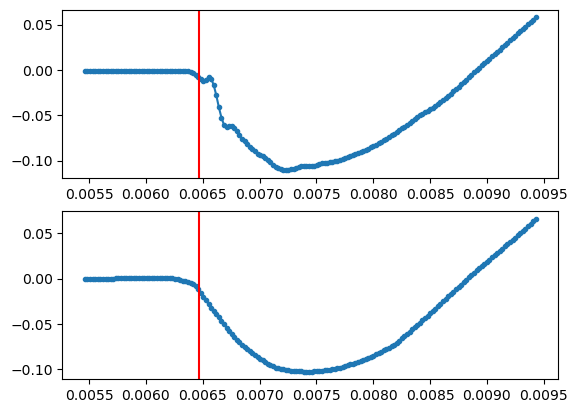

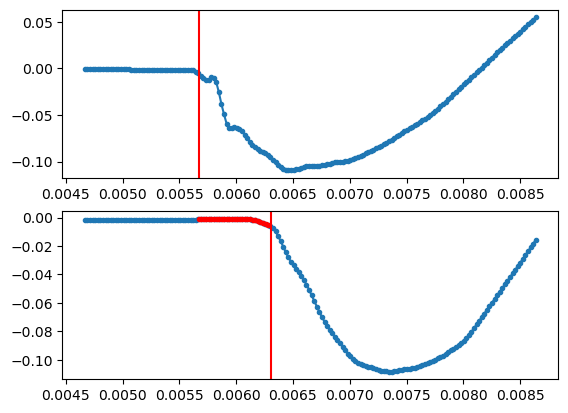

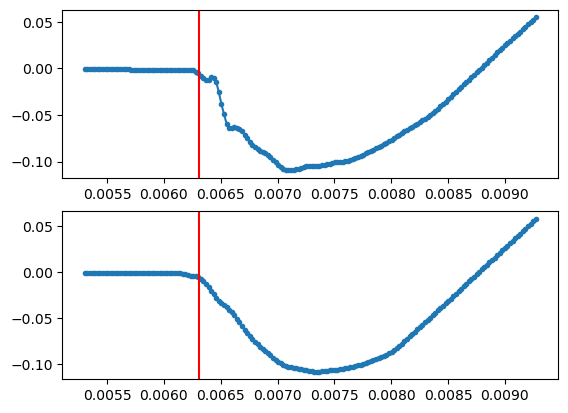

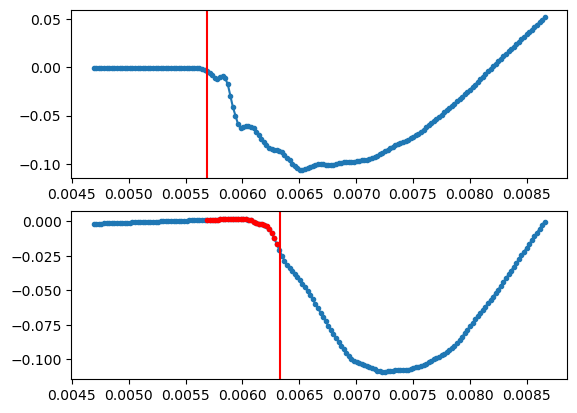

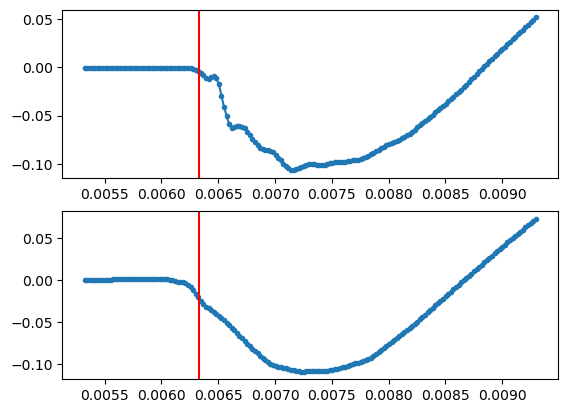

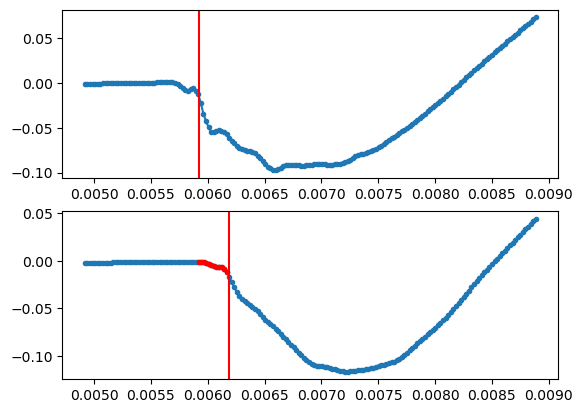

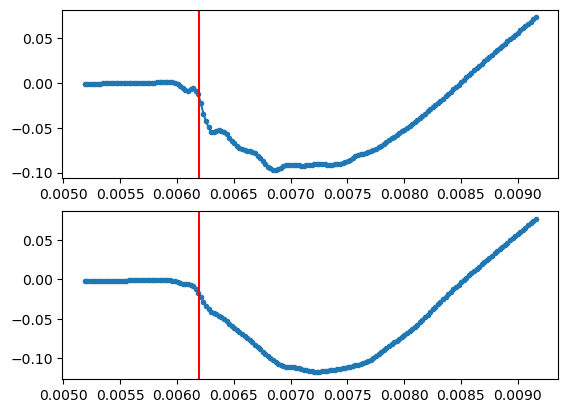

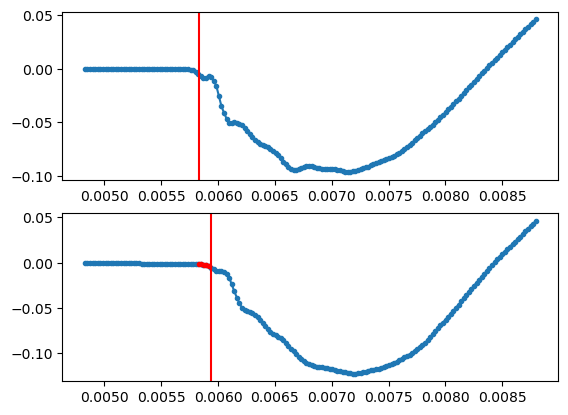

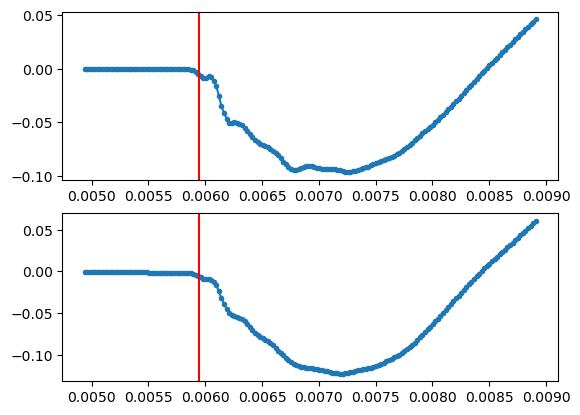

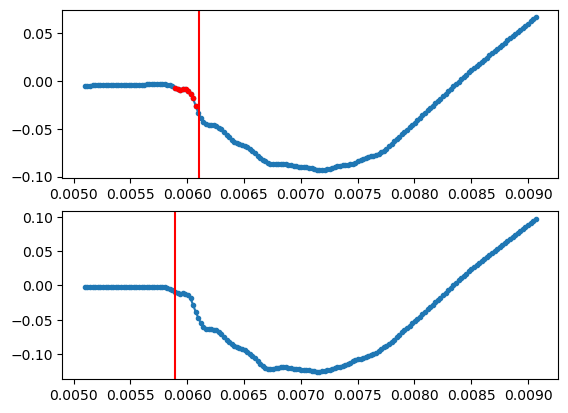

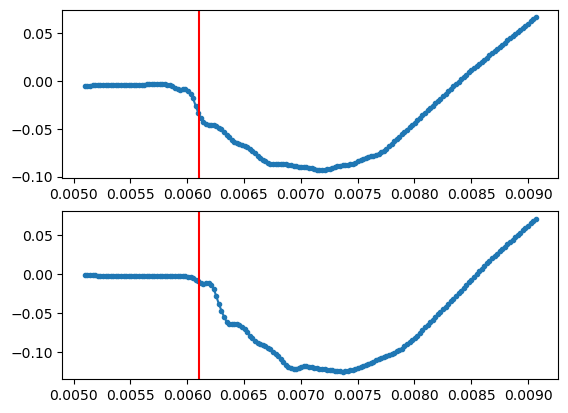

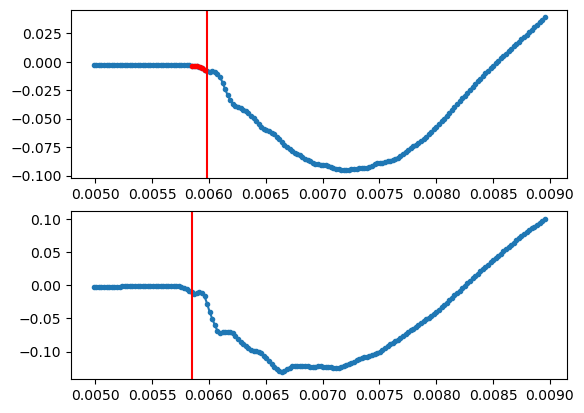

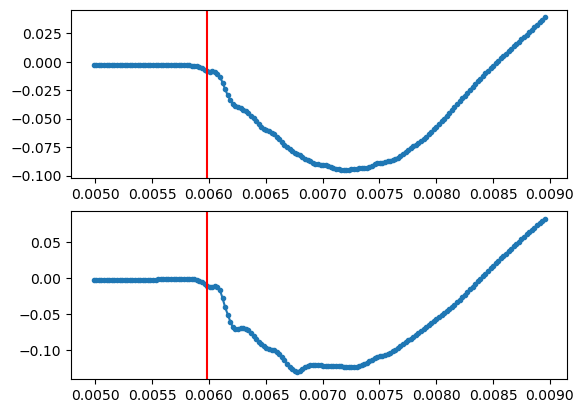

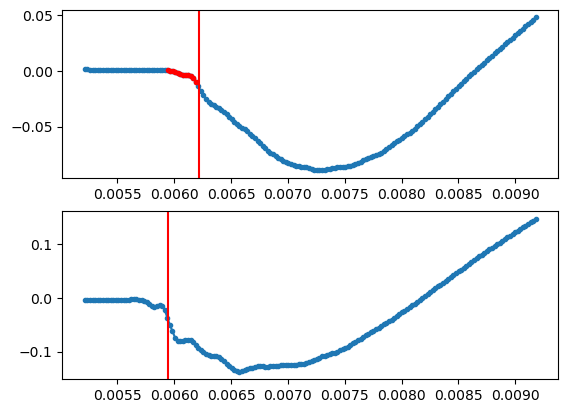

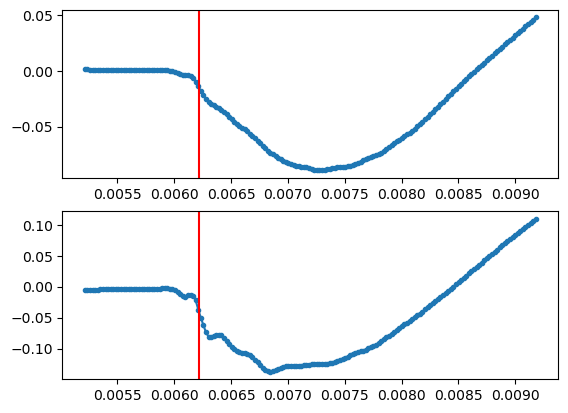

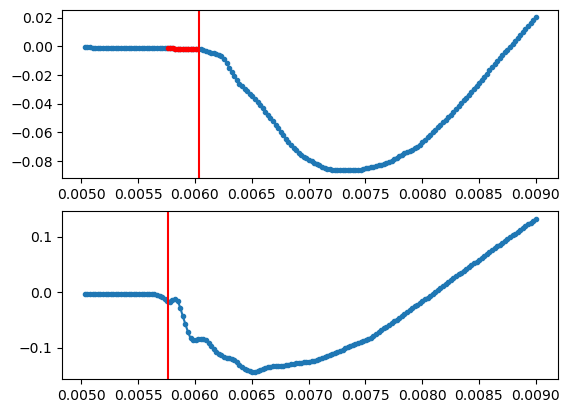

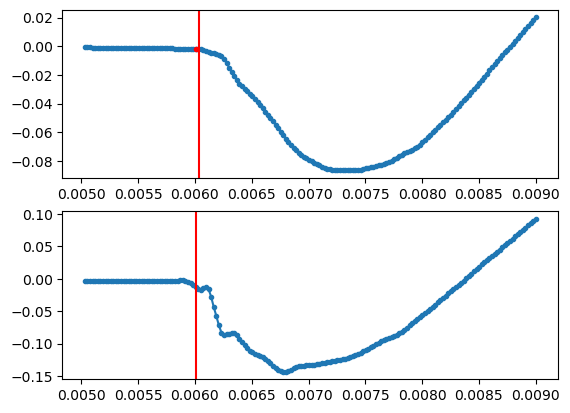

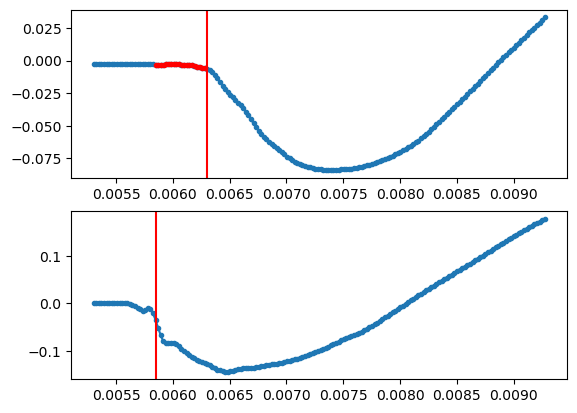

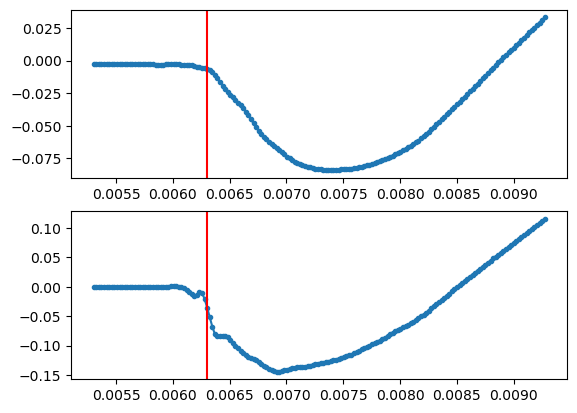

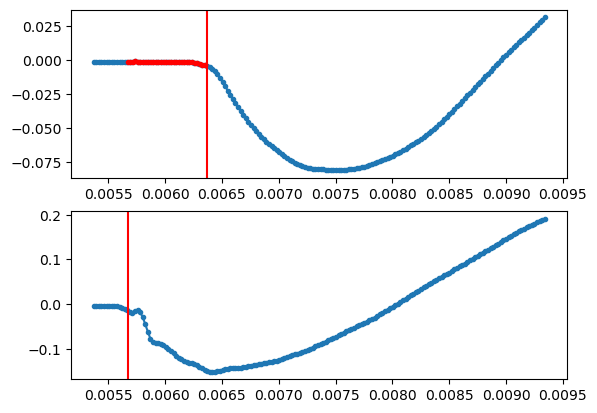

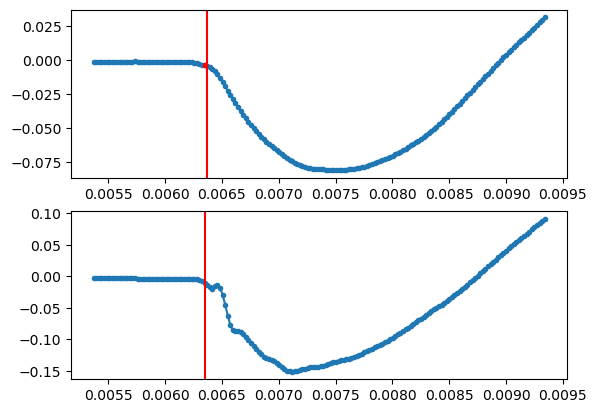

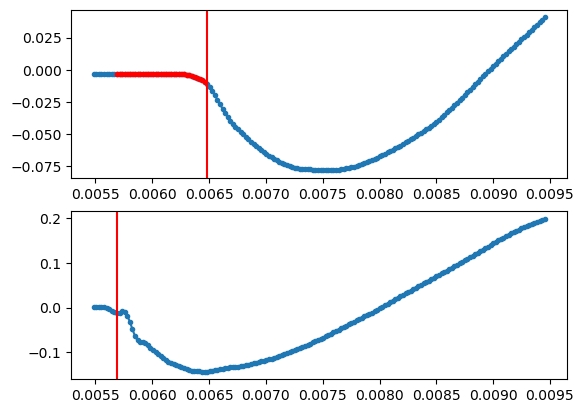

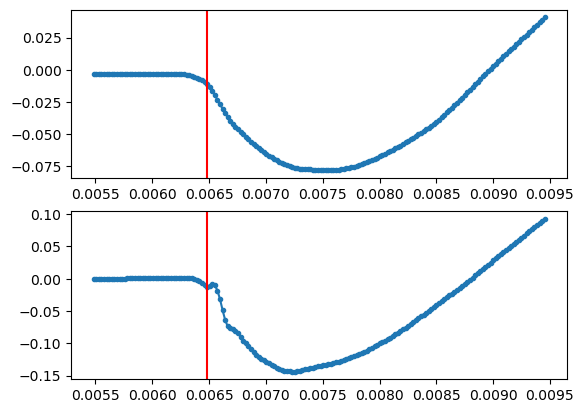

In [67]:
print("WHEN USING HRTF ESTIMATE")
for ANGLE in range(-90,91,15):
    logger.setLevel(logging.WARNING)
    itd = apply_ILD_only_HRTF(sound,ANGLE,STRAT=ITD_STRATEGY.ESTIMATE_FROM_HRTF)
    print(itd)